In [7]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Fonction : Conversion Excel -> datetime
def excel_vers_datetime(date_excel):
    if pd.isna(date_excel):
        return pd.NaT
    try:
        return pd.to_datetime('1900-01-01') + pd.to_timedelta(date_excel - 2, unit='D')
    except:
        return pd.NaT

# Fonction : Nettoyage et préparation des données
def charger_et_nettoyer_donnees(fichier):
    donnees = pd.read_excel(fichier)

    # Détection des colonnes d'horodatage
    colonnes_horodatage = [
        col for col in donnees.columns 
        if donnees[col].dtype == 'float64' and str(donnees[col].iloc[0]).startswith('45791')
    ]
    if not colonnes_horodatage:
        raise ValueError("Aucune colonne d'horodatage détectée.")

    # Conversion des dates
    for col in colonnes_horodatage:
        donnees[col] = donnees[col].apply(excel_vers_datetime)
    donnees['Horodatage_Unifié'] = donnees[colonnes_horodatage[0]]
    donnees.drop(columns=colonnes_horodatage, inplace=True)

    # Colonnes utiles
    colonnes_utiles = [
        'Débit d\'entrée d\'acide m3/h',
        'Débit de vapeur Kg/h',
        'Température de sortie évaporateur en C°',
        'Vide bouilleur en torr',
        'Densité de sortie',
        'Horodatage_Unifié'
    ]
    donnees = donnees[[col for col in donnees.columns if col in colonnes_utiles]]

    # Interpolation des valeurs manquantes
    donnees = donnees.interpolate(method='linear', limit_direction='both')

    # Suppression des débits nuls/négatifs
    donnees = donnees[
        (donnees["Débit d'entrée d'acide m3/h"] > 0) &
        (donnees["Débit de vapeur Kg/h"] > 0)
    ]

    # Détection des outliers (basé sur l'IQR pour Densité_Sortie)
    Q1 = donnees['Densité de sortie'].quantile(0.25)
    Q3 = donnees['Densité de sortie'].quantile(0.75)
    IQR = Q3 - Q1
    donnees = donnees[
        (donnees['Densité de sortie'] >= Q1 - 1.5 * IQR) &
        (donnees['Densité de sortie'] <= Q3 + 1.5 * IQR)
    ]

    # Format datetime
    donnees['Horodatage_Unifié'] = donnees['Horodatage_Unifié'].dt.strftime('%m/%d/%Y %H:%M')

    # Renommage
    donnees.columns = [
        'Débit_Acide_m3h',
        'Débit_Vapeur_kgh',
        'Température_Évaporateur_C',
        'Vide_Bouilleur_torr',
        'Densité_Sortie',
        'Horodatage_Unifié'
    ]
    donnees = donnees[
        ['Horodatage_Unifié', 'Débit_Acide_m3h', 'Débit_Vapeur_kgh',
         'Température_Évaporateur_C', 'Vide_Bouilleur_torr', 'Densité_Sortie']
    ]

    # Sauvegarde
    donnees.to_excel("donnees_nettoyees.xlsx", index=False)
    
    # Afficher les corrélations
    print("📊 Corrélations avec Densité_Sortie :")
    print(donnees.corr(numeric_only=True)['Densité_Sortie'])
    
    return donnees

# Fonction : Entraînement du modèle Random Forest uniquement
def entrainer_meilleur_modele(donnees):
    donnees['Horodatage_Unifié'] = pd.to_datetime(donnees['Horodatage_Unifié'], format='%m/%d/%Y %H:%M')
    X = donnees[['Débit_Acide_m3h', 'Débit_Vapeur_kgh', 'Température_Évaporateur_C', 'Vide_Bouilleur_torr']]
    y = donnees['Densité_Sortie']

    y_mean = y.mean()
    y_centered = y - y_mean

    X_train, X_test, y_train, y_test = train_test_split(X, y_centered, test_size=0.2, random_state=42)

    pipeline_rf = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(random_state=42))
    ])

    param_grid_rf = {
        'rf__n_estimators': [50, 100],
        'rf__max_depth': [None, 10]
    }

    grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search_rf.fit(X_train, y_train)

    best_model = grid_search_rf.best_estimator_
    print("🔎 Meilleur modèle : Random Forest")
    print("🔎 Meilleurs paramètres RF :", grid_search_rf.best_params_)

    cv_scores = cross_val_score(best_model, X, y_centered, cv=5, scoring='neg_mean_squared_error')
    mean_cv_mse = -cv_scores.mean()
    print("📈 MSE moyenne (CV imbriquée) :", mean_cv_mse)

    y_pred = best_model.predict(X_test)
    y_pred_uncentered = y_pred + y_mean
    y_test_uncentered = y_test + y_mean
    mse_test = mean_squared_error(y_test_uncentered, y_pred_uncentered)
    r2_test = r2_score(y_test_uncentered, y_pred_uncentered)
    print("📊 Test R2 :", r2_test)
    print("📉 Test MSE :", mse_test)

    joblib.dump(best_model, 'modele_final.pkl')
    print("✅ Modèle Random Forest sauvegardé sous 'modele_final.pkl'")
    with open("y_mean.txt", "w") as f:
        f.write(str(y_mean))
    return best_model, y_mean

# Fonction : Prédiction sur nouvelles données
def predire_nouvelles_donnees(model, y_mean):
    exemples = pd.DataFrame({
        'Débit_Acide_m3h': [30.0, 29.9, 29.8],
        'Débit_Vapeur_kgh': [3525, 3550, 3580],
        'Température_Évaporateur_C': [92.36, 92.35, 92.34],
        'Vide_Bouilleur_torr': [59.1, 59.0, 58.9]
    })
    predictions = model.predict(exemples) + y_mean  # Revenir à l'échelle originale
    print("🔮 Prédictions sur nouveaux exemples :")
    print(predictions)
    return predictions

# Exécution principale
if __name__ == "__main__":
    fichier = 'DATA-CONC1-140525-050625.xlsx'
    donnees = charger_et_nettoyer_donnees(fichier)
    modele, y_mean = entrainer_meilleur_modele(donnees)
    predire_nouvelles_donnees(modele, y_mean)

📊 Corrélations avec Densité_Sortie :
Débit_Acide_m3h             -0.219043
Débit_Vapeur_kgh            -0.160979
Température_Évaporateur_C   -0.053643
Vide_Bouilleur_torr          0.050154
Densité_Sortie               1.000000
Name: Densité_Sortie, dtype: float64
🔎 Meilleur modèle : Random Forest
🔎 Meilleurs paramètres RF : {'rf__max_depth': None, 'rf__n_estimators': 100}
📈 MSE moyenne (CV imbriquée) : 3875.7047089727666
📊 Test R2 : 0.920376917545218
📉 Test MSE : 357.34772595847977
✅ Modèle Random Forest sauvegardé sous 'modele_final.pkl'
🔮 Prédictions sur nouveaux exemples :
[1729.98173828 1730.5723938  1731.36580933]


In [2]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import joblib
import numpy as np

# Charger le modèle
model = joblib.load("modele_final.pkl")

# Charger la moyenne y_mean
with open("y_mean.txt", "r") as f:
    
    y_mean = float(f.read())

# Champs d'entrée avec haute précision
debit_acide = widgets.FloatText(value=30.0011291503906, step=0.0000001, description="Acide (m³/h):")
debit_vapeur = widgets.FloatText(value=3525.123456789, step=0.000001, description="Vapeur (Kg/h):")
temperature = widgets.FloatText(value=92.3600000001, step=0.000001, description="Température (°C):")
vide = widgets.FloatText(value=59.123456, step=0.000001, description="Vide (Torr):")

button = widgets.Button(description="🔮 Prédire")
output = widgets.Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        X = pd.DataFrame([{
            'Débit_Acide_m3h': debit_acide.value,
            'Débit_Vapeur_kgh': debit_vapeur.value,
            'Température_Évaporateur_C': temperature.value,
            'Vide_Bouilleur_torr': vide.value
        }])
        pred = model.predict(X)[0] + y_mean
        print(f"✅ Densité prédite : {pred:.6f}")

button.on_click(on_button_clicked)

# Interface
ui = widgets.VBox([
    widgets.HTML("<h3>Entrez les paramètres pour la prédiction :</h3>"),
    debit_acide,
    debit_vapeur,
    temperature,
    vide,
    button,
    output
])
display(ui)

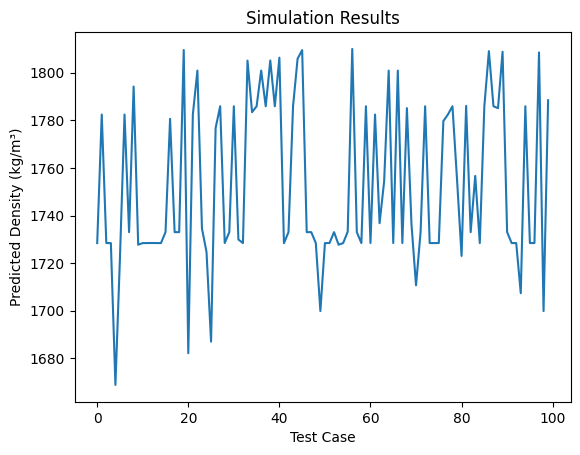

In [6]:
import joblib
import numpy as np
import pandas as pd
from scipy.stats import uniform

# Charger le modèle
model = joblib.load("modele_final.pkl")

# Charger la moyenne y_mean
with open("y_mean.txt", "r") as f:
    
    y_mean = float(f.read())
# Generate test data
n_tests = 100
test_data = pd.DataFrame({
    'Débit_Acide_m3h': uniform.rvs(0, 100, size=n_tests),
    'Débit_Vapeur_kgh': uniform.rvs(0, 10000, size=n_tests),
    'Température_Évaporateur_C': uniform.rvs(0, 200, size=n_tests),
    'Vide_Bouilleur_torr': uniform.rvs(0, 760, size=n_tests)
})

# Predict
predictions = model.predict(test_data) + y_mean

# Visualize
import matplotlib.pyplot as plt
plt.plot(predictions)
plt.xlabel('Test Case')
plt.ylabel('Predicted Density (kg/m³)')
plt.title('Simulation Results')
plt.show()
